# 🧪 Custom kNN Classification With LSH

In this notebook, we implement kNN with LSH **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `KNeighborsClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
from collections import defaultdict
from itertools import product
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [3]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall and F1-score — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average="weighted")
        recall = recall_score(y, y_pred, average="weighted")
        f1 = f1_score(y, y_pred, average="weighted")

        evaluations.loc[:, name] = [accuracy, precision, recall, f1]

    return evaluations.astype(float)

In [4]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [5]:
# Generate dataset
X, y = make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_classes=4,
    n_clusters_per_class=1,
    n_redundant=0,
    class_sep=1.8,
    random_state=42,
)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [7]:
class EuclideanLSH:
    """Locality-Sensitive Hashing (LSH) for approximate nearest neighbor search.

    Attributes:
        num_hashes (int): Number of hash functions (i.e., hyperplanes).
        dim (int): Dimensionality of the input data.
        r (int): Width of each hash bin.
        w (NDArray[np.float64]): Random projection vectors (shape: [num_hashes, dim]).
        b (NDArray[np.float64]): Random biases (shape: [num_hashes]).
        buckets (dict[tuple, list[int]]): Hash table mapping hash keys to
            list of indices.
        data (NDArray[np.float64] | None): Data matrix after calling `fit()`.
    """

    def __init__(
        self, num_hashes: int, dim: int, r: int, random_state: int | None = 42
    ) -> None:
        """Initialize the LSH structure.

        Args:
            num_hashes (int): Number of hash functions.
            dim (int): Dimensionality of the input data.
            r (int): Bucket width (affects quantization of projections).
            random_state (int | None): Random seed for reproducibility (default: 42).
        """
        self.num_hashes = num_hashes
        self.dim = dim
        self.r = r

        self.buckets: dict[tuple, list] = defaultdict(list)
        self.data: NDArray[np.float64] | None = None

        if random_state is not None:
            np.random.seed(random_state)

        self.w = np.random.randn(num_hashes, dim)
        self.b = np.random.uniform(0, r, size=num_hashes)

    def _hash(self, x: NDArray[np.float64]) -> NDArray[np.int64]:
        """Compute the LSH hash code for a single vector.

        Args:
            x (NDArray[np.float64]): Input vector of shape (dim,).

        Returns:
            NDArray[np.int64]: Hash code of shape (num_hashes,).
        """
        projections = np.dot(self.w, x) + self.b
        return np.floor(projections / self.r).astype(int)

    def _hash_batch(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Compute LSH hash codes for a batch of vectors.

        Args:
            X (NDArray[np.float64]): Data matrix of shape (n_samples, dim).

        Returns:
            NDArray[np.int64]: Hash codes of shape (n_samples, num_hashes).
        """
        projections = np.dot(X, self.w.T) + self.b
        return np.floor(projections / self.r).astype(int)

    def fit(self, X: NDArray[np.float64]) -> None:
        """Index the dataset by hashing each data point into buckets.

        Args:
            X (NDArray[np.float64]): Data matrix of shape (n_samples, dim).
        """
        self.data = X
        hashes = self._hash_batch(X)

        for idx, h in enumerate(hashes):
            key = tuple(h)
            self.buckets[key].append(idx)

    def query(
        self, x: NDArray[np.float64], top_k: int, search_radius: int = 1
    ) -> list[int]:
        """Query the LSH index for approximate nearest neighbors.

        Args:
            x (NDArray[np.float64]): Query point of shape (dim,).
            top_k (int): Number of approximate nearest neighbors to return.
            search_radius (int): Number of hash bucket offsets to search
                if the initial bucket is empty (default: 1).

        Returns:
            list[int]: List of indices of the top-k approximate nearest neighbors
                in the original dataset.
        """
        q_hash = self._hash(x)
        key = tuple(q_hash)
        candidates_idx = self.buckets.get(key, [])

        if not candidates_idx:
            candidates_idx = []
            offsets = list(
                product(range(-search_radius, search_radius + 1), repeat=len(q_hash))
            )
            for offset in offsets:
                neighbor_key = tuple(
                    h + o for h, o in zip(q_hash, offset, strict=False)
                )
                candidates_idx.extend(self.buckets.get(neighbor_key, []))

        if not candidates_idx:
            return []

        candidates = self.data[candidates_idx]
        dists = np.linalg.norm(candidates - x, axis=1)
        nearest = np.argsort(dists)[:top_k]

        return [candidates_idx[i] for i in nearest]

In [8]:
class MyKNeighborsClassifier:
    """K-Nearest Neighbors Classifier with Gaussian kernel weighting & lsh.

    Predicts the class label for each input sample based on the weighted vote
    of its k nearest neighbors in the training data, using Minkowski distance
    and a Gaussian kernel to assign weights to neighbors.

    Attributes:
        k_neighbors (int): Number of nearest neighbors to consider.
        h (float): Bandwidth parameter for the Gaussian kernel.
        r (int): Bucket width (affects quantization of projections).
        X_train (NDArray[np.float64] | None): Training features.
        y_train (NDArray[np.float64] | None): Training labels.
        lsh (EuclideanLSH | None): Training kd tree.
    """

    def __init__(self, k_neighbors: int = 3, h: float = 1.0, r: int = 1) -> None:
        """Initialize the KNN classifier.

        Args:
            k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
            h (float, optional): Bandwidth parameter for the Gaussian kernel.
                Defaults to 1.0.
            r (int): Bucket width (affects quantization of projections).
                Defaults to 1.0.
        """
        self.k_neighbors = k_neighbors
        self.h = h
        self.r = r

        self.X_train: NDArray[np.float64] | None = None
        self.y_train: NDArray[np.int64] | None = None
        self.lsh: EuclideanLSH | None = None

    def _gaussian_kernel(self, t: NDArray[np.float64]) -> NDArray[np.float64]:
        """Gaussian (normal) kernel function.

        Args:
            t (NDArray[np.float64]): Input values.

        Returns:
            NDArray[np.float64]: Kernel-weighted values.
        """
        return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Store training data for future predictions.

        Args:
            X (NDArray[np.float64]): Training feature matrix of shape
                (n_samples, n_features).
            y (NDArray[np.int64]): Target values of shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y
        self.lsh = EuclideanLSH(num_hashes=10, dim=X.shape[1], r=self.r)
        self.lsh.fit(X)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        y_pred = []
        for x_new in X:
            neighbor_idx = self.lsh.query(x_new, self.k_neighbors)

            neighbors = X_train[neighbor_idx]
            neighbor_distances = np.linalg.norm(neighbors - x_new, axis=1)
            neighbor_labels = y_train[neighbor_idx]

            weights = self._gaussian_kernel(neighbor_distances / self.h)

            class_weights = {}
            for label, weight in zip(neighbor_labels, weights, strict=False):
                class_weights[label] = class_weights.get(label, 0) + weight

            predicted_label = max(class_weights, key=class_weights.get)
            y_pred.append(predicted_label)

        return np.array(y_pred, dtype=np.int64)

### 🏋️‍♂️ Model Training

In [ ]:
# Scikit-learn kNN classifier model
sklearn_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
sklearn_model.fit(X_train, y_train)

# My kNN classifier with lsh model
my_model = MyKNeighborsClassifier(k_neighbors=5, r=7, h=5.8)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [ ]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my lsh": my_model.predict(X_test),
}

In [11]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my lsh
Accuracy,0.981000,0.982000
Precision,0.981001,0.982025
Recall,0.981000,0.982000
F1-score,0.980981,0.981986


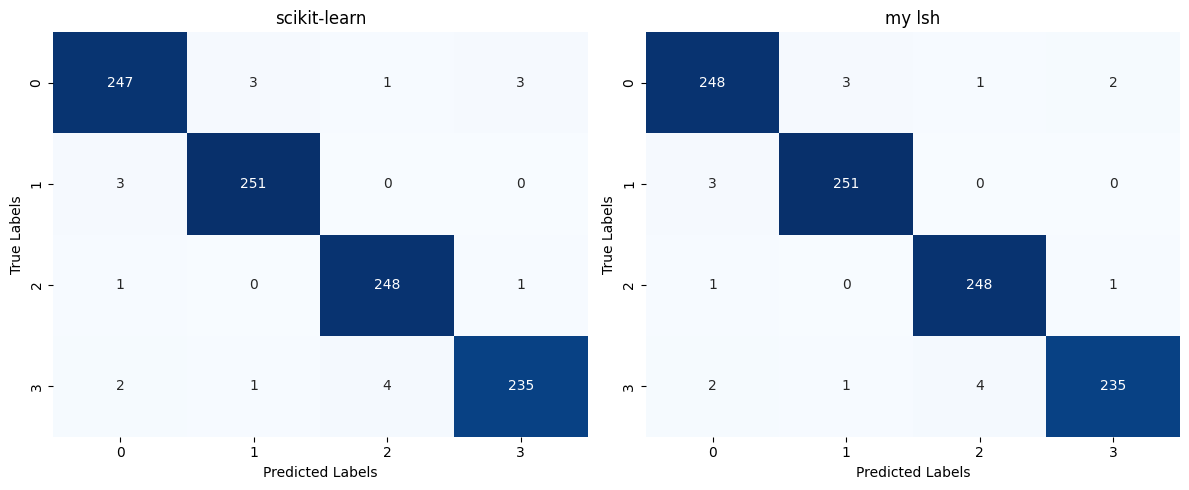

In [12]:
plot_confusion_matrices(predictions, y_test)